<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/Barrages/Simul_EbbGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from typing import Callable, List, Tuple
from dataclasses import dataclass, field
import matplotlib.pyplot as mpl
import numpy as np

In [19]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py &> /dev/null

import mpl_utils as mut
mut.config_plots()
mpl.rcParams["figure.figsize"] = (12, 3)
%config InlineBackend.figure_formats = ['svg']

# Algebraic models

## Barrage simulator in ebb mode

The following models were implemented to simulate the tidal power plant:

* The basin
* The tide
* Hydraulic turbines
* Electrical generators
* Sluice gates
* Power plant controller

## Turbine hill map and turbine operating curve

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/TurbineGeneratorMaps/TurbineHill_Plot.svg" width="500px" style="display:inline">


### Turbine mode

Turbine dimensionless numbers

* Rotational speed $$n_{11}=\dfrac{\Omega D}{\sqrt{gh}}.$$

* Flow rate $$Q_{11} = \dfrac{Q}{D^2\sqrt{gh}}.$$

* Efficiency $$\eta_\mathrm{turb} = \dfrac{P_\mathrm{turb}}{P_\mathrm{avail}}.$$


The power available to the turbine is given by 

$$P_\mathrm{avail} = \rho g h Q,$$

where

$$Q = D^2 \sqrt{gh} \, Q_{11}\!\big( n_{11} \big).$$

The turbine is to be operated at constant rotational speed due to the use of a synchronous generator (see generator class).

The available energy is

$$\dfrac{\text{d} E_\text{avail}}{\text{d}t} = P_\text{avail}.$$

The energy harvest by the turbine is

$$\dfrac{\text{d} E_\text{turb}}{\text{d}t}=\eta_\text{turb}\big( n_{11}\big) \, P_\text{avail},$$

The mean turbine efficiency is 

$$\overline{\eta_\text{turb}} = \dfrac{E_\text{turb}}{E_\text{avail}}.$$

### Sluicing mode

The in sluicing mode the "turbine" is modelled as 

$$Q_\mathrm{turb}^\mathrm{sluice} = C_\mathrm{d} A_\mathrm{turb} \sqrt{ 2 g h }$$

where $A_\mathrm{turb}$ is the area corresponding to the turbine rotor diameter.



In [20]:
@dataclass
class TurbineModel:

  # flow rate: efficiency: red line of the map 
  poly_CQ1: np.poly1d = np.poly1d( np.array([0.16928201, 0.08989368]) )

  # flow rate: green line of the map
  poly_CQ2: np.poly1d = np.poly1d( np.array([-3.63920467e-04,  9.37677378e-03, 
                                         -9.25873626e-02,  1.75687197e+00]) )

  # efficiency: red line of the map
  poly_CE1: np.poly1d = np.poly1d( np.array([-0.02076456, 0.20238444, 
                                              0.48984553]) )
  # efficiency: green line of the map
  poly_CE2: np.poly1d = np.poly1d( np.array([-2.75685709e-04,  2.04822984e-03,  
                                             6.86081825e-04,  7.93083108e-01]) )

  # n11 interpolation domain
  n11_min: float =  4.38
  n11_max: float = 17.17

  # other data
  ga: float = 9.8         # gravity aceleration
  ρw: float = 1025.0      # water density
  CD_sluice: float = 1.0  # discharge coefficient in sluice mode

  #=============================================================================
  def __init__( self, D_turb, Omega ) -> None:

    self.Omega = Omega    # we are assuming constant rotational speed model
    self.D_turb = D_turb  # turbine rotor diameter
    self.A_turb = np.pi*(D_turb/2.0)**2 

    # constants used in for computing n11 and QT
    self.CT0 = Omega * D_turb / np.sqrt( self.ga )
    self.CT1 = D_turb**2 * np.sqrt( self.ga )

  def n11_range( self ) -> tuple:
    return ( self.n11_min, self.n11_max )

  # dimensionless velocity
  def n11( self, h: float ) -> float:
    # avoid division by zero on h = 0.0
    return self.CT0 / np.sqrt( max( h, 1E-3 ) ) 

  # dimensionless flow rate
  def Q11( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < 7.92193:
      return self.poly_CQ1( n11 ) 
    else:
      return self.poly_CQ2( n11 )

  # efficiency
  def eta( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < 7.92193:
      return self.poly_CE1( n11 ) * 0.912
    else:
      return self.poly_CE2( n11 ) * 0.912

  # computing operational data
  def operating_point( self, h: float ) -> float:
    n11 = self.n11( h )
    QT = self.CT1 * self.Q11( n11 ) * np.sqrt( h )
    PH = self.ρw * self.ga * h * QT
    ηT = self.eta( n11 )
    return QT, PH, ηT  
  
  # turbine flow rate in sluice mode
  def sluicing( self, h: float ) -> float:
    QS = -self.CD_sluice * self.A_turb * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

## Generator efficiency curve

The electrical generator is assumed to be a synchronous machine. The rotational speed is given by

$$\Omega = \dfrac{2\pi f}{p}$$

where $f$ is the electrical grid frequency and $p$ is the number of pairs of poles.

<br />

The generator efficiency is computed as a function of the load

$$\Lambda = \dfrac{P_\mathrm{turb}}{P_\mathrm{gen}^\mathrm{rated}}$$


<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/TurbineGeneratorMaps/GeneratorEff_plot.svg" width="400px" style="display:inline">

Electrical power output is

$$P_\mathrm{gen} =\eta_\mathrm{gen}(\Lambda) \, P_\mathrm{turb},$$

and the converted energy is

$$\dfrac{\mathrm{d} E_\mathrm{gen}}{\mathrm{d} t} = P_\mathrm{gen}.$$

The mean generator efficiency is

$$\overline{\eta_\mathrm{gen}}=\dfrac{E_\mathrm{gen}}{E_\mathrm{turb}}.$$



In [21]:
@dataclass
class GeneratorModel:

  # red part of the curve
  poly_C1: np.poly1d = np.poly1d( np.array([-6.71448631e+03,  2.59159775e+03, 
                                            -3.80834059e+02,  2.70423225e+01, 
                                             3.29394948e-03]) )
  # green part of the curve
  poly_C2: np.poly1d = np.poly1d( np.array([-1.16856952,  3.31172525, 
                                            -3.44296217,  1.5416029 ,  
                                             0.71040716]) )
    
  #=============================================================================
  def __init__( self, Pgen_rated: float ) -> None:
    self.Pgen_rated = Pgen_rated

  # efficiency as a function of the load
  def eta( self, Pturb: float ) -> float:
    load = Pturb / self.Pgen_rated

    assert( load >= 0.0 ), "turbine power lower than zero"
    assert( load <= 1.0 ), "generator rated power to low (%f)" % Pturb
    if load < 0.12542:
      return self.poly_C1( load ) 
    else:
      return self.poly_C2( load )

## Sluice gates

The sluice gates are modelled as a turbulent pressure drop

$$Q_\mathrm{sluice} = C_\mathrm{d} A \sqrt{ 2 g h }$$

typical discharge coefficients for barrage sluice gates are within the range $0.8 \le C_\mathrm{d} \le 1.2$. Here we use $C_\mathrm{d}=1.0$. 

In [22]:
@dataclass
class GateModel:
  ga: float = 9.8
  CD_sluice: float = 1.0

  #=============================================================================
  def __init__( self, Area: float ) -> None:
    self.Area = Area

  # flow rate as a function of h
  def sluicing( self, h: float ) -> float:
    QS = -self.CD_sluice * self.Area * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

## Tide modelling

The tide level is assumed to be a trignometric series

$$\zeta(t) = \sum_i^n A_i \cos\left( \omega_i t + \phi_i \right).$$

In [23]:
@dataclass
class TideModel:
 
  # A_tide, period and φ_tide are vectors to allow simulate multi-component tides
  def __init__( self, A_tide: np.array, ω_tide: np.array, φ_tide:np.array ) -> None:
      self.A_tide = A_tide
      self.ω_tide = ω_tide 
      self.φ_tide = φ_tide
    
  # tide level as a function t
  def level( self, t: float ) -> float:    
      return np.sum( self.A_tide * np.cos( self.ω_tide * t + self.φ_tide ) )

# Differential models

## Basin modelling

The basin is modelled as a "shoe box". The out flow is denoted as positive.

<br />

The instantaneous basin volume is computed from

$$\dfrac{\mathrm{d}V}{\mathrm{d}t}=-Q.$$
<br />

Knowing that $V=A_\mathrm{basin} z$, the basin height is computed from

$$\dfrac{\mathrm{d}z}{\mathrm{d}t}=-q_\mathrm{basin}.$$

where $z$ is the water level with respect to the mean water level (MWL), $A_\mathrm{basin}$ is the basin area and $q_\mathrm{basin} = Q/A_\mathrm{basin}$.
<br/>
<br/>

Integrating with the Euler method in $\Delta t$, we get

$$z(t+\Delta t)=z(t) + \Delta t\,(-q_\mathrm{basin}).$$

<br/>

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/BasinShoeBox_MWL.svg" width="500px" style="display:inline">



## Power plant operation model 

The power plant modelling and control is based in the following finite state machine

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/BarrageEbbMode.svg" width="700px" style="display:inline">

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/EbbOperation_FSM.svg" width="700px" style="display:inline">

# Finite State Machine simulator

In [24]:
func_state = Callable[ [ float, float, np.array ], List[ np.array ] ]
func_transition = Callable[ [ float, np.array, np.array ], int ]


class FSM_simulator:


  def __init__( self, simul_time: float, Delta_t: float, n_vars: int, n_outs: int ) -> None:
    self.dic_states = {}
    self.dic_transitions = {}

    self.n_time = int( simul_time / Delta_t) + 1 
    self.n_time = self.n_time
    self.n_vars = n_vars
    self.n_outs = n_outs
    
    self.time = np.linspace( 0, simul_time, self.n_time )
    self.delta_t = self.time[1]

    self.vars = np.zeros( (n_vars, self.n_time) )
    self.outs = np.zeros( (n_outs, self.n_time) )
    self.states = np.zeros( self.n_time )
    
    self.t = 0

  def run_simulator( self, state: int, vars: np.array ) -> Tuple[np.array]:
    self.vars[:,0] = vars
    self.states[0] = state
    # outs not available at t=0

    for i in range( 1, self.n_time ):
      self.t = self.time[i-1]
      vars, outs = self.__run_state( state, self.delta_t, self.time[i-1], vars )
      state = self.__test_transitions( state, self.time[i-1], vars, outs )
 
      self.vars[:,i] = vars
      self.outs[:,i] = outs
      self.states[i] = state

    return ( self.time, self.states, self.vars, self.outs )


  def add_state( self, state: int, func: func_state ) -> None:
    assert state not in self.dic_states.keys(), "state already define"      
    self.dic_states[state] = func


  def add_transition( self, state: int, func: func_transition ) -> None:
    if state not in self.dic_transitions.keys():
      self.dic_transitions[state] = [ func ]
    else:
      self.dic_transitions[state].append( func )


  # private member
  def __run_state( self, state: int, delta_t: float, t: float, vars: np.array ) -> List[np.array]:
    return self.dic_states[ state ]( delta_t, t, vars )
 

  # private member
  def __test_transitions( self, state: int, t: float, vars: np.array, outs: np.array ) -> int:
    for transition in self.dic_transitions[ state ]:
      new_state = transition( t, vars, outs )  
      if new_state != state:
        return new_state # first transition that changes the state
    return state

## Vars used in the simulation

$$ \mathbf{x} = 
\begin{pmatrix} z & E_\mathrm{avail} & E_\mathrm{turb} & E_\mathrm{gen} \end{pmatrix}^\mathrm{T} $$ 

## Outputs

$$ \mathbf{y} = 
\begin{pmatrix} h & \zeta & Q_\mathrm{turb} & Q_\mathrm{sluice} & 
P_\mathrm{avail} & P_\mathrm{turb} & P_\mathrm{gen} &
\eta_\mathrm{turb} & \eta_\mathrm{gen} \end{pmatrix}^\mathrm{T} $$ 

In [25]:
@dataclass
class Models:

    A_basin: float = 22E6 
    
    n_turbs: int = 24
    Dturb: float = 6.0 
    
    grid_freq: float = 50.0
    ppoles: int = 32
    Pgen_rated: float = 25E6 
                  
    n_gates: int = 6
    Agates: float = 10.0*15.0

    #===========================================================================    
    # post init variables

    # tide components
    ζ: np.array = field(init=False) # amplitudes
    ω: np.array = field(init=False) # frequencies (rad/hour => rad/s)
    φ: np.array = field(init=False) # phases

    Omega: float = field(init=False)
    n11_max: float = field(init=False)

    turbine: TurbineModel = field(init=False)
    generator: GeneratorModel = field(init=False)

    gate: GateModel = field(init=False)
    tide: TideModel = field(init=False)


    def __init__( self, ζ: np.array, ω: np.array, φ: np.array ) -> None:

      self.ζ = ζ
      self.ω = ω
      self.φ = φ

      # synchronous rotational speed
      self.Omega = 2 * np.pi * self.grid_freq / self.ppoles

      self.turbine = TurbineModel( D_turb = self.Dturb, Omega = self.Omega )
      self.generator = GeneratorModel( Pgen_rated = self.Pgen_rated )
      
      _, self.n11_max = self.turbine.n11_range()

      self.gate = GateModel( Area = self.Agates )
      self.tide = TideModel( self.ζ, self.ω, self.φ )


    # minimum turbine head that starts turbine generation 
    def turbine_starting_head( self, t: float ) -> float:
      return 5.0

    ## STATES ##################################################################
    def S1_Generate( self, delta_t: float, t: float, vars: np.array ) -> List[np.array]:

      z = vars[0]
      ζ = self.tide.level( t )
      h = z - ζ

      Q_sluice = 0.0
      Q_turb, P_avail, η_turb = self.turbine.operating_point( h )
      P_turb = η_turb * P_avail

      η_gen = self.generator.eta( P_turb )
      P_gen  = η_gen * P_turb

      q_basin = Q_turb * self.n_turbs / self.A_basin
      RHS = np.array( ( -q_basin, P_avail, P_turb, P_gen ) ) 

      # variables at ( t + delta_t )
      vars = vars + delta_t * RHS

      #=========================================================================
      # outputs at ( t + delta_t )
      z = vars[0]
      ζ = self.tide.level( t + delta_t )
      h = z - ζ

      Q_turb, P_avail, η_turb = self.turbine.operating_point( h )
      P_turb = η_turb * P_avail

      η_gen = self.generator.eta( P_turb )
      P_gen  = η_gen * P_turb

      outs = np.array( ( h, ζ, Q_turb, Q_sluice, P_avail, P_turb, P_gen, η_turb, η_gen ) )
      
      return ( vars, outs ) 


    def S024_Hold( self, delta_t: float, t: float, vars: np.array ) -> List[np.array]:

      #=========================================================================
      # outputs at ( t + delta_t )
      z = vars[0]
      ζ = self.tide.level( t + delta_t )
      h = z - ζ

      Q_turb = Q_sluice = P_avail = P_turb = P_gen = η_turb = η_gen = 0.0

      outs = np.array( ( h, ζ, Q_turb, Q_sluice, P_avail, P_turb, P_gen, η_turb, η_gen ) )
      
      # vars do not change
      return ( vars, outs ) 


    def S3_Fill( self, delta_t: float, t: float , vars: np.array ) -> List[np.array]:

      z = vars[0]
      ζ = self.tide.level( t )
      h = z - ζ

      Q_sluice = self.gate.sluicing( h )
      Q_turb = self.turbine.sluicing( h )

      P_avail = P_turb = P_gen = η_turb = η_gen = 0.0

      q_sluice = Q_sluice * self.n_gates
      q_turb = Q_turb * self.n_turbs
      q_basin = ( q_sluice + q_turb ) / self.A_basin
      RHS = np.array( ( -q_basin, 0.0, 0.0, 0.0 ) ) 

      # variables at ( t + delta_t )
      vars = vars + delta_t * RHS

      #=========================================================================
      # outputs at ( t + delta_t )
      z = vars[0]
      ζ = self.tide.level( t + delta_t )
      h = z - ζ

      Q_sluice = self.gate.sluicing( h )
      Q_turb = self.turbine.sluicing( h )
      outs = np.array( ( h, ζ, Q_turb, Q_sluice, P_avail, P_turb, P_gen, η_turb, η_gen ) )

      return ( vars, outs ) 


    ## TRANSITIONS #############################################################
    def T_S0_S1( self, t: float, vars: np.array, outs: np.array ) -> int:
      h = outs[0]
      h_start = models.turbine_starting_head( t )
      return 1 if h > h_start else 0

    def T_S1_S2( self, t: float, vars: np.array, outs: np.array ) -> int:
      h = outs[0]
      n11 = self.turbine.n11( h )
      return 2 if n11*1.1 > self.n11_max else 1

    def T_S2_S3( self, t: float, vars: np.array, outs: np.array ) -> int:
      h = outs[0]
      return 3 if h < 0.0 else 2

    def T_S3_S4( self, t: float, vars: np.array, outs: np.array ) -> int:
      h = outs[0]
      return 4 if h > 0.0 else 3

    def T_S4_S1( self, t: float, vars: np.array, outs: np.array ) -> int:
      h = outs[0]
      h_start = models.turbine_starting_head( t )
      return 1 if h > h_start else 4

In [26]:
ζ = np.array( [ 4.18, 1.13 ] )                # amplitudes
ω = np.array( [ 0.5058/3600, 0.5236/3600 ] )  # frequencies (rad/hour => rad/s)
φ = np.array( [ -3.019, -3.84 ] )             # phases

if len( ω ) == 2:
  tide_period = 1.0 / ( np.max( ω[1] ) - np.min( ω[0] ) ) * 2.0*np.pi
else:
  tide_period = 1.0 / ω[0] * 2.0*np.pi

simul_time = 4.0*tide_period
delta_t = 100.0

z0_basin = 1.0 # initial basin level

In [27]:
models = Models( ζ, ω, φ )

n_vars = 4
n_outs = 9

simul = FSM_simulator( simul_time, delta_t, n_vars, n_outs )

simul.add_state( 0, models.S024_Hold )
simul.add_state( 1, models.S1_Generate )
simul.add_state( 2, models.S024_Hold )
simul.add_state( 3, models.S3_Fill )
simul.add_state( 4, models.S024_Hold )

simul.add_transition( 0, models.T_S0_S1 )
simul.add_transition( 1, models.T_S1_S2 )
simul.add_transition( 2, models.T_S2_S3 )
simul.add_transition( 3, models.T_S3_S4 )
simul.add_transition( 4, models.T_S4_S1 )

# Simulate the power plant

In [28]:
vars = np.array( (z0_basin, 0.0, 0.0, 0.0) )

time_vec, states_vec, vars, outs = simul.run_simulator( 0, vars )

#=================================
z_vec = vars[0]

E_avail_vec = vars[1]
E_turb_vec  = vars[2]
E_gen_vec   = vars[3]

#=================================
h_vec = outs[0]
ζ_vec = outs[1]

Q_turb_vec   = outs[2]
Q_sluice_vec = outs[3]

P_avail_vec = outs[4]
P_turb_vec  = outs[5]
P_gen_vec   = outs[6]
η_turb_vec  = outs[7]
η_gen_vec   = outs[8]

In [35]:
hours_vec = time_vec / 3600.0
period_hours = tide_period / 3600.0

# Number of points of each period. Required to make the mean of last period
pp = int( tide_period / delta_t )

P_turb_max = np.max( P_turb_vec )
P_turb_mean = np.mean( P_turb_vec[-pp:] )
P_gen_mean = np.mean( P_gen_vec[-pp:] )
C_fac = P_gen_mean / models.generator.Pgen_rated

print( "Max instantaneous power per turbine = %.2f MW" % (P_turb_max/1E6) ) 
print()
print( "Mean turbine power    = %.2f MW" % (P_turb_mean*models.n_turbs/1E6) ) 
print( "Mean electrical power = %.2f MW" % (P_gen_mean*models.n_turbs/1E6) ) 
print()
print( "Capacity factor = %.2f" % C_fac )

Max instantaneous power per turbine = 19.23 MW

Mean turbine power    = 86.00 MW
Mean electrical power = 81.87 MW

Capacity factor = 0.14


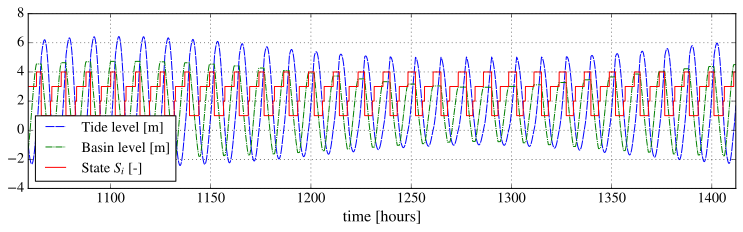

In [30]:
mpl.plot( hours_vec, h_vec, label='Tide level [m]', dashes=(9,1) )
mpl.plot( hours_vec, z_vec, label='Basin level [m]', dashes=(7,1,1,1) )
mpl.plot( hours_vec, states_vec, label='State $S_i$ [-]' )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid();

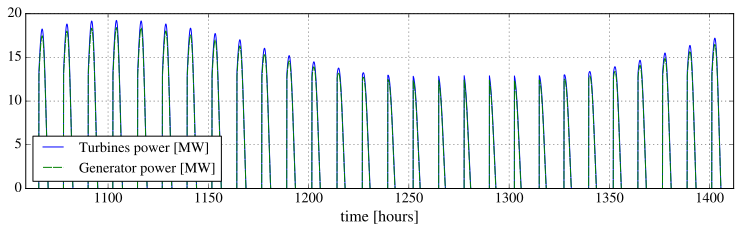

In [31]:
mpl.plot( hours_vec, P_turb_vec/1E6, label='Turbines power [MW]'  )
mpl.plot( hours_vec, P_gen_vec/1E6, label='Generator power [MW]', dashes=(9,1) )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid();

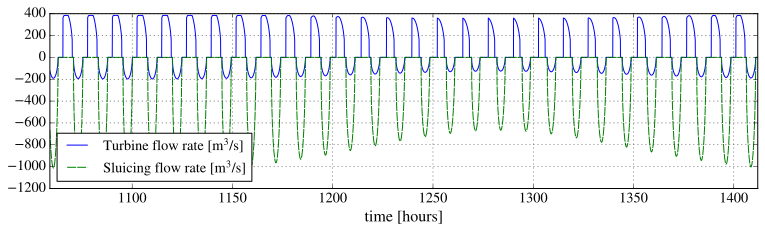

In [32]:
mpl.plot( hours_vec, Q_turb_vec, label='Turbine flow rate [m$^3$/s]' )
mpl.plot( hours_vec, Q_sluice_vec, label='Sluicing flow rate [m$^3$/s]', dashes=(9,1) )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid();

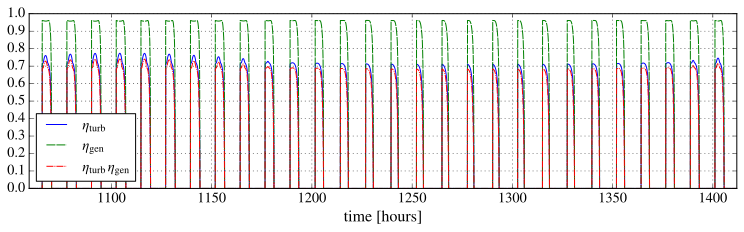

In [33]:
mpl.plot( hours_vec, η_turb_vec, label='$\eta_\mathrm{turb}$' )
mpl.plot( hours_vec, η_gen_vec, label='$\eta_\mathrm{gen}$', dashes=(9,1) )
mpl.plot( hours_vec, η_turb_vec*η_gen_vec, label='$\eta_\mathrm{turb}\,\eta_\mathrm{gen}$', dashes=(7,1,1,1) )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.gca().set_yticks(np.arange( 0, 1.01, 0.1) )
mpl.grid();

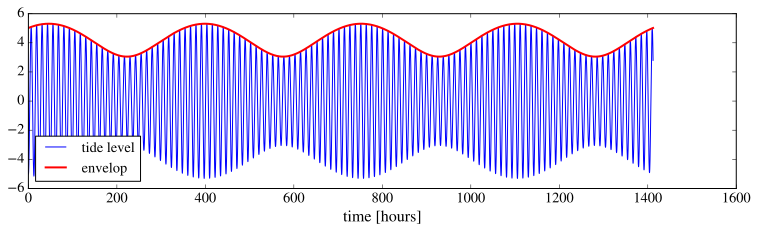

In [34]:
if len( ω ) == 2:
  X1 = ζ[0]
  X2 = ζ[1]
  ωm = ω[0] - ω[1]
  φm = φ[0] - φ[1]
  ev = np.sqrt(X1**2 + X2**2 + 2*X1*X2*np.cos( ωm*time_vec + φm ) )

  mpl.plot( hours_vec, ζ_vec, label="tide level" )
  mpl.plot( hours_vec, ev, 'r-', lw=2, label="envelop" )
  #mpl.xlim( 3*period_hours, 4*period_hours )
  mpl.xlabel( 'time [hours]' )
  mpl.legend(loc='lower left');
else:
  print( "No envelop to plot" );